In [1]:
!pip install coral_pytorch

In [2]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import v2
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import timm
import random
import shutil
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pytorch_lightning as pl
from coral_pytorch.dataset import corn_label_from_logits
from coral_pytorch.losses import corn_loss

In [3]:
def import_dataset(clip_limit=None,tilegridsize=None,Clahe = False):
    
    if Clahe:
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tilegridsize)
    
    train_dict = {}
    val_dict = {}
    test_dict = {}
    
    train_path = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/train/"
    val_path = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/val/"
    test_path = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/test/"
    
    for label in os.listdir(train_path):
        train_dict[int(label)] = os.listdir(train_path + label)
    for label in os.listdir(test_path):
        test_dict[int(label)] = os.listdir(test_path + label)
    for label in os.listdir(val_path):
        val_dict[int(label)] = os.listdir(val_path + label)
        
    train_images = {}
    val_images = {}
    test_images = {}
    
    for keys in train_dict.keys():  
        normal_train_images = [np.array(Image.open(train_path + str(keys) + "/" + images)) for images in train_dict[keys]]
        normal_test_images = [np.array(Image.open(test_path + str(keys) + "/" + images)) for images in test_dict[keys]]
        normal_val_images = [np.array(Image.open(val_path + str(keys) + "/" + images)) for images in val_dict[keys]]
        
        if Clahe:
            clahe_train_images = [clahe.apply(np.array(Image.open(train_path + str(keys) + "/" + images))) for images in train_dict[keys]]
            clahe_test_images = [clahe.apply(np.array(Image.open(test_path + str(keys) + "/" + images))) for images in test_dict[keys]]
            clahe_val_images = [clahe.apply(np.array(Image.open(val_path + str(keys) + "/" + images))) for images in val_dict[keys]]
            
            train_images[keys] =  clahe_train_images
            test_images[keys] =  clahe_test_images
            val_images[keys] =  clahe_val_images
            
        else:
            train_images[keys] = normal_train_images
            test_images[keys] = normal_test_images
            val_images[keys] = normal_val_images 
            
            
    return train_images,test_images,val_images

In [4]:
def create_tensors(train_images,test_images,val_images):
    
    trlabel0 = [0 for i in range(len(train_images[0]))]
    trlabel1 = [1 for i in range(len(train_images[1]))]
    trlabel2 = [2 for i in range(len(train_images[2]))]
    trlabel3 = [3 for i in range(len(train_images[3]))]
    trlabel4 = [4 for i in range(len(train_images[4]))]
    
    tslabel0 = [0 for i in range(len(test_images[0]))]
    tslabel1 = [1 for i in range(len(test_images[1]))]
    tslabel2 = [2 for i in range(len(test_images[2]))]
    tslabel3 = [3 for i in range(len(test_images[3]))]
    tslabel4 = [4 for i in range(len(test_images[4]))]
    
    vlabel0 = [0 for i in range(len(val_images[0]))]
    vlabel1 = [1 for i in range(len(val_images[1]))]
    vlabel2 = [2 for i in range(len(val_images[2]))]
    vlabel3 = [3 for i in range(len(val_images[3]))]
    vlabel4 = [4 for i in range(len(val_images[4]))]
    
    
    training_image  = torch.tensor(torch.cat((torch.tensor(train_images[0]),torch.tensor(train_images[1]),torch.tensor(train_images[2]),torch.tensor(train_images[3]),torch.tensor(train_images[4])),0),dtype = torch.float32)
    training_labels = torch.tensor(torch.cat((torch.tensor(trlabel0),torch.tensor(trlabel1),torch.tensor(trlabel2),torch.tensor(trlabel3),torch.tensor(trlabel4)),0))
    training_image = training_image.view(training_image.shape[0],1,224,224)
    
    testing_image  = torch.tensor(torch.cat((torch.tensor(test_images[0]),torch.tensor(test_images[1]),torch.tensor(test_images[2]),torch.tensor(test_images[3]),torch.tensor(test_images[4])),0),dtype = torch.float32)
    testing_labels = torch.tensor(torch.cat((torch.tensor(tslabel0),torch.tensor(tslabel1),torch.tensor(tslabel2),torch.tensor(tslabel3),torch.tensor(tslabel4)),0))
    testing_image = testing_image.view(testing_image.shape[0],1,224,224)
    
    val_image  = torch.tensor(torch.cat((torch.tensor(val_images[0]),torch.tensor(val_images[1]),torch.tensor(val_images[2]),torch.tensor(val_images[3]),torch.tensor(val_images[4])),0),dtype = torch.float32)
    val_labels = torch.tensor(torch.cat((torch.tensor(vlabel0),torch.tensor(vlabel1),torch.tensor(vlabel2),torch.tensor(vlabel3),torch.tensor(vlabel4)),0))
    val_image = val_image.view(val_image.shape[0],1,224,224)
    
    return training_image,training_labels,testing_image,testing_labels,val_image,val_labels

In [5]:
def create_dataset(training_image,training_labels,testing_image,testing_labels,val_image,val_labels,batch_size = 4):
    train_dataset = TensorDataset(training_image,training_labels)
    val_dataset = TensorDataset(val_image,val_labels)
    test_dataset = TensorDataset(testing_image,testing_labels)
    
    train_loader = DataLoader(train_dataset,shuffle= True , batch_size = batch_size)
    val_loader = DataLoader(val_dataset,shuffle = True , batch_size = batch_size)
    test_loader = DataLoader(test_dataset,shuffle = True, batch_size = batch_size)
    
    return train_loader,test_loader,val_loader

In [6]:
original_model= torchvision.models.vgg19_bn(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:03<00:00, 154MB/s]  


In [7]:
original_model.features[0] = nn.Conv2d(1,64,kernel_size = (3,3),stride = 1,padding = 1)

In [8]:
original_model.avgpool = nn.AvgPool2d(2)
original_model.classifier = nn.Sequential(
                            nn.Linear(512*3,512),
                            nn.BatchNorm1d(512),
                            nn.ReLU(inplace = True),
                            nn.Linear(512,4))

In [21]:
def testing(model,test_loader):
    device = 'cuda'
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        test_loss = 0.0
        test_accuracy = 0
        for i,(images, labels) in enumerate(test_loader):

            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            
            loss = corn_loss(outputs, labels, 5)
            
            
            predicted_labels = corn_label_from_logits(outputs).float()
            
            n_samples += labels.size(0)
            n_correct += (predicted_labels == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())

        
        confusion_mat = confusion_matrix(all_labels, all_predictions)


        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network on the {n_samples} test images:{acc:.4f}%')
        
        return confusion_mat
    

In [10]:
train_images,test_images,val_images = import_dataset(clip_limit = 0.04,tilegridsize=(8,8),Clahe = False)

In [11]:
training_image,training_labels,testing_image,testing_labels,val_image,val_labels = create_tensors(train_images,test_images,val_images)

In [12]:
tr_image = training_image[:,:,65:180,:]
ts_image = testing_image[:,:,65:180,:]
v_image = val_image[:,:,65:180,:]

In [13]:
train_loader,test_loader,val_loader = create_dataset(tr_image,training_labels,ts_image,testing_labels,v_image,val_labels,batch_size = 4)

In [14]:
no_of_layers = 16
for i, params in enumerate(original_model.parameters()):
    if i < no_of_layers:
        params.requires_grad = False

In [15]:
original_model.to('cuda')

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [16]:
optimizer = torch.optim.AdamW(original_model.parameters(),lr = 0.0001)

In [19]:
epochs = 8
training_loss = 0.0
training_accuracy = 0
validation_accuracy = 0
device = 'cuda'
for epoch in range(epochs):
    n_samples_train = 0
    n_samples_val = 0
    original_model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = original_model(images)
        
        loss = corn_loss(output, labels, 5)
        n_samples_train += labels.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        predicted_labels = corn_label_from_logits(output).float()
        training_accuracy += (predicted_labels == labels).sum().item()

        if (i + 1) % 512 == 0:
            print(f'Training - Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {loss.item():.4f}')

    print(f'Training Accuracy - Epoch: {epoch + 1}: {training_accuracy * 100 / n_samples_train:.2f}%')
    training_accuracy = 0
    
    original_model.eval()
    with torch.no_grad():
        for i, (val_images, val_labels) in enumerate(val_loader):

            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_output = original_model(val_images)
            
            loss = corn_loss(val_output,val_labels, 5)
            
            predicted_labels = corn_label_from_logits(val_output).float()
            
            validation_accuracy += (predicted_labels == val_labels).sum().item()
            n_samples_val += val_labels.size(0)

    print(f'Validation Accuracy - Epoch: {epoch + 1}: {validation_accuracy * 100 / n_samples_val:.2f}% Loss: {loss.item():.4f}')
    validation_accuracy = 0

Training - Epoch: 1, Batch: 512, Loss: 0.5810
Training - Epoch: 1, Batch: 1024, Loss: 0.5805
Training Accuracy - Epoch: 1: 60.97%
Validation Accuracy - Epoch: 1: 59.08% Loss: 0.3145
Training - Epoch: 2, Batch: 512, Loss: 0.5763
Training - Epoch: 2, Batch: 1024, Loss: 0.3953
Training Accuracy - Epoch: 2: 64.42%
Validation Accuracy - Epoch: 2: 58.96% Loss: 0.1145
Training - Epoch: 3, Batch: 512, Loss: 0.9604
Training - Epoch: 3, Batch: 1024, Loss: 0.8581
Training Accuracy - Epoch: 3: 66.10%
Validation Accuracy - Epoch: 3: 60.77% Loss: 0.4608
Training - Epoch: 4, Batch: 512, Loss: 0.6366
Training - Epoch: 4, Batch: 1024, Loss: 0.2059
Training Accuracy - Epoch: 4: 66.41%
Validation Accuracy - Epoch: 4: 61.62% Loss: 0.2889
Training - Epoch: 5, Batch: 512, Loss: 0.3395
Training - Epoch: 5, Batch: 1024, Loss: 0.2347
Training Accuracy - Epoch: 5: 68.85%
Validation Accuracy - Epoch: 5: 60.29% Loss: 0.8381
Training - Epoch: 6, Batch: 512, Loss: 0.2279
Training - Epoch: 6, Batch: 1024, Loss: 0.65

In [23]:
for i, params in enumerate(original_model.parameters()):
        if i < no_of_layers:
            params.requires_grad = True

In [24]:
epochs = 8
training_loss = 0.0
training_accuracy = 0
validation_accuracy = 0
device = 'cuda'
for epoch in range(epochs):
    n_samples_train = 0
    n_samples_val = 0
    original_model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = original_model(images)
        
        loss = corn_loss(output, labels, 5)
        n_samples_train += labels.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        predicted_labels = corn_label_from_logits(output).float()
        training_accuracy += (predicted_labels == labels).sum().item()

        if (i + 1) % 512 == 0:
            print(f'Training - Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {loss.item():.4f}')

    print(f'Training Accuracy - Epoch: {epoch + 1}: {training_accuracy * 100 / n_samples_train:.2f}%')
    training_accuracy = 0
    
    original_model.eval()
    with torch.no_grad():
        for i, (val_images, val_labels) in enumerate(val_loader):

            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_output = original_model(val_images)
            
            loss = corn_loss(val_output,val_labels, 5)
            
            predicted_labels = corn_label_from_logits(val_output).float()
            
            validation_accuracy += (predicted_labels == val_labels).sum().item()
            n_samples_val += val_labels.size(0)

    print(f'Validation Accuracy - Epoch: {epoch + 1}: {validation_accuracy * 100 / n_samples_val:.2f}% Loss: {loss.item():.4f}')
    validation_accuracy = 0

Training - Epoch: 1, Batch: 512, Loss: 0.1251
Training - Epoch: 1, Batch: 1024, Loss: 0.0753
Training Accuracy - Epoch: 1: 75.42%
Validation Accuracy - Epoch: 1: 60.65% Loss: 0.4893
Training - Epoch: 2, Batch: 512, Loss: 0.1482
Training - Epoch: 2, Batch: 1024, Loss: 0.1817
Training Accuracy - Epoch: 2: 77.22%
Validation Accuracy - Epoch: 2: 60.17% Loss: 0.0617
Training - Epoch: 3, Batch: 512, Loss: 0.1734
Training - Epoch: 3, Batch: 1024, Loss: 0.0624
Training Accuracy - Epoch: 3: 80.22%
Validation Accuracy - Epoch: 3: 61.26% Loss: 0.3401
Training - Epoch: 4, Batch: 512, Loss: 0.3572
Training - Epoch: 4, Batch: 1024, Loss: 0.2526
Training Accuracy - Epoch: 4: 82.78%
Validation Accuracy - Epoch: 4: 58.47% Loss: 1.3106
Training - Epoch: 5, Batch: 512, Loss: 0.2815
Training - Epoch: 5, Batch: 1024, Loss: 0.2241
Training Accuracy - Epoch: 5: 84.18%
Validation Accuracy - Epoch: 5: 60.05% Loss: 0.0192
Training - Epoch: 6, Batch: 512, Loss: 0.3390
Training - Epoch: 6, Batch: 1024, Loss: 0.24

In [25]:
conf_mat = testing(original_model,test_loader)

Accuracy of the network on the 1656 test images:63.4058%


In [27]:
confusion_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

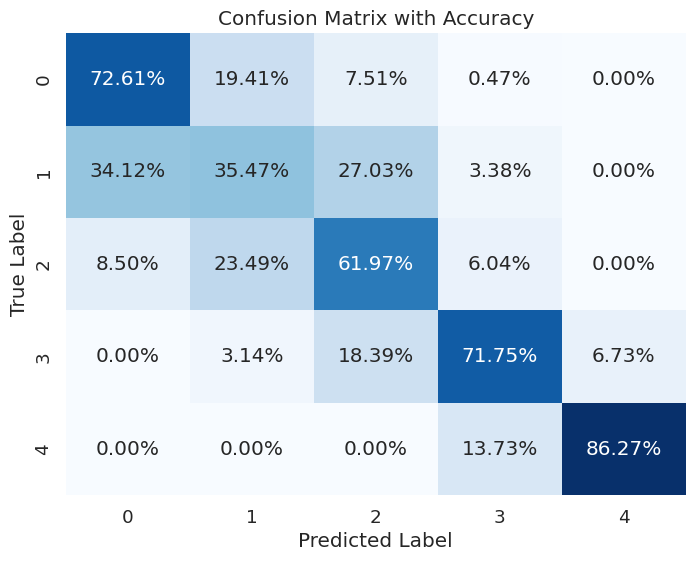

In [28]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mat_norm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix with Accuracy")
plt.show()